In [1]:
# run the header that sets up the environment

already_run = globals().get("already_run", False)
if not (already_run):
    already_run = True
    %run header.ipynb

Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


1.30.0
c:\Users\andre\OneDrive\Bildung\3_HHU\quant_Bio\6th\BA\QTB_modeling\analyses
c:\Users\andre\OneDrive\Bildung\3_HHU\quant_Bio\6th\BA\QTB_modeling


In [2]:
def get_minmax(s,T_END):
    c = s.get_full_results_df()
    v = s.get_fluxes_df()
    
    cmin = c.loc[T_END*0.75:,:].min()
    cmax = c.loc[T_END*0.75:,:].max()
    vmin = v.loc[T_END*0.75:,:].min()
    vmax = v.loc[T_END*0.75:,:].max()
    
    return cmin, cmax, vmin, vmax

In [3]:
def get_avg(s, T_END):
    """
    Compute the average values of concentrations and fluxes over the last 25% of the simulation time.
    """
    
    c = s.get_full_results_df()
    v = s.get_fluxes_df()
    
    # Compute the average fluxes over the last 25% of the simulation
    vavg = pd.Series(
        integrate.trapezoid(
            v.loc[T_END*0.75:,:],  # Select the last 25% of the time range
            x=v.loc[T_END*0.75:,:].index,  # Use time as the x-axis
            axis=0
        ) / (T_END - v.loc[T_END*0.75:,:].index.min()),  # Normalize by time range
        index=v.columns  # Assign column names
    )

    # Compute the average concentrations over the last 25% of the simulation
    cavg = pd.Series(
        integrate.trapezoid(
            c.loc[T_END*0.75:,:],  # Select the last 25% of the time range
            x=c.loc[T_END*0.75:,:].index,  # Use time as the x-axis
            axis=0
        ) / (T_END - v.loc[T_END*0.75:,:].index.min()),  # Normalize by time range
        index=c.columns  # Assign column names
    )

    return cavg.T, vavg.T  # Return the transposed averages of concentrations and fluxes


In [39]:

def pfd_ss_scan(s: object, pfd_values: np.ndarray, y0_loop: dict, debug: bool =False) -> tuple:
    """
    Perform a steady-state scan by varying the parameter "pfd" across different values.

    Returns:
    tuple:
        - DataFrame of steady-state concentrations (rows: pfd values, columns: compound names).
        - DataFrame of steady-state fluxes (rows: pfd values, columns: reaction rates).
    """

    backup_y0 = y0_loop.copy()  # Backup the conditions to reset the system if needed

    fluxes = {}  # store steady-state fluxes for each pfd value
    concentrations = {}  # store steady-state concentrations for each pfd value
    failed_cases = []

    # Iterate over each pfd value with a progress bar
    for x in tqdm(pfd_values, total=len(pfd_values)):  

        #print("y0_loop", y0_loop)

        #if any(not isinstance(s, (float, np.float64)) for s in y0_loop):
        #    y0_loop = backup_y0.copy()
        #    print("resetting y0_loop")

        s.initialise(y0_loop)  # Reset the system with the given initial conditions
        s.update_parameter("pfd", x)  # Update the parameter "pfd" to the current value
        
        try:
            # Simulate until steady state is reached
            t, y = s.simulate_to_steady_state()

            if y is None or len(y) == 0:  # Check for invalid output
                raise ValueError(f"Simulation returned empty result at pfd={x}")

            # Store the final steady-state concentrations
            concentrations[x] = s.get_full_results_array()[-1]

            # Store the final steady-state fluxes
            fluxes[x] = s.model.get_fluxes_array(y=y, t=t)[-1]

            # Update initial conditions for the next iteration
            y0_loop = s.get_new_y0()

        except Exception as e:
            logger.warning(f"Simulation failed at pfd={x}: {e}")
            failed_cases.append(x)

            # Store NaNs for failed cases
            all_compounds = s.model.get_all_compounds()
            rate_names = s.model.get_rate_names()
            concentrations[x] = np.full(len(all_compounds), np.nan)
            fluxes[x] = np.full(len(rate_names), np.nan)

            # If debug mode is enabled, log additional details
            if debug:
                logger.debug(f"Failed pfd={x}. Initial conditions: {y0_loop}")

    # Log summary after execution
    logger.info(f"Simulation completed. {len(failed_cases)} cases failed: {failed_cases}")

    return (
        pd.DataFrame(concentrations, index=s.model.get_all_compounds()).T,  # Convert concentration results to DataFrame
        pd.DataFrame(fluxes, index=s.model.get_rate_names()).T  # Convert flux results to DataFrame
    )

NUM_SCANS = 10
LOW_LIGHT = 100
HIGH_LIGHT = 1500
PFD_VALUES = np.linspace(LOW_LIGHT, HIGH_LIGHT, NUM_SCANS)

y0 = {
    "PQ": 11.248282037382348,       "PC": 1.3639930534269078,       "Fd": 4.207984023619571,
    "ATP": 1.6085042256522668,      "NADPH": 0.45672250689837696,   "H": 0.002174958602661375,
    "LHC": 0.8079188314632375,      "Psbs": 0.9626375680773129,     "Vx": 0.9570474456930378,
    "PGA": 0.6109221284988471,      "BPGA": 0.0003235574325883373,  "GAP": 0.003190323205250446,
    "DHAP": 0.07018710225866034,    "FBP": 0.0015898274733035427,   "F6P": 0.0886998278393475,
    "G6P": 0.20400960399249862,     "G1P": 0.011832557030606641,    "SBP": 0.003215008299488195,
    "S7P": 0.02811069161049136,     "E4P": 0.003523560381569699,    "X5P": 0.006746131132013272,
    "R5P": 0.011299769265221232,    "RUBP": 0.030373422172205858,   "RU5P": 0.004519907641254276,
    "MDA": 2.2718326276618075e-06,
#    "ASC": 9.999997726884683,
    "H2O2": 1.3296482521160688e-06,
    "DHA": 1.2828228406972059e-09,
#    "GSH": 9.999999998752703,
    "GSSG": 6.236645512101874e-10,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
    "P700FA": 1.4731,            #eq at pfd 800       #"PSItot": 2.5, (in parameter vector of Matuszynska)
    "P700+FA-": 0.0131,
    "P700FA-": 0.0177,
}

In [40]:
s = Simulator(get_model())
c_ss_petc, v_ss_petc = pfd_ss_scan(s, PFD_VALUES, y0, True)

100%|██████████| 10/10 [00:11<00:00,  1.10s/it]
2025-03-24 20:06:10,280 - INFO - Simulation completed. 0 cases failed: []


<Axes: title={'center': 'electron carriers'}>

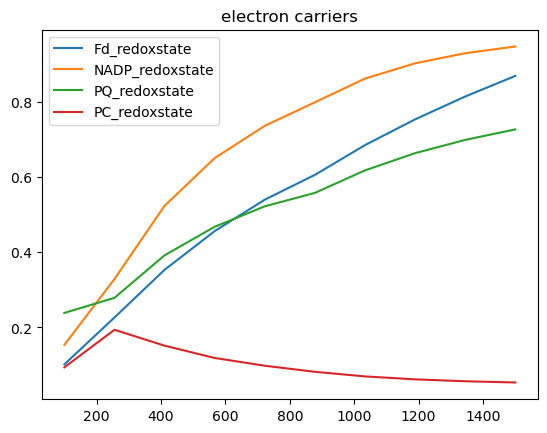

In [36]:
c_ss_petc.loc[:, ["Fd_redoxstate","NADP_redoxstate","PQ_redoxstate","PC_redoxstate"]].plot(title="electron carriers")

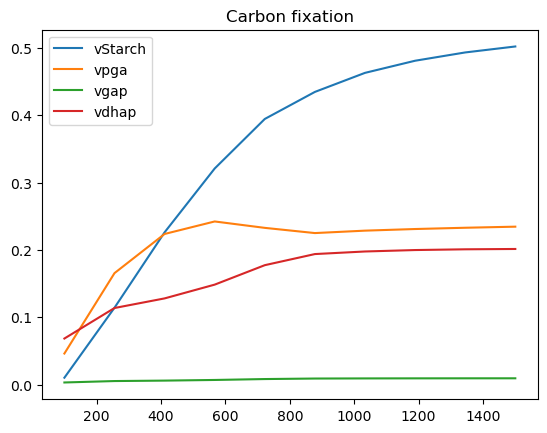

In [37]:
v_ss_petc.loc[:, ["vStarch", "vpga", "vgap", "vdhap"]].plot(title="Carbon fixation")
plt.show()